# Load data 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
print(fm.findfont("Arial", fallback_to_default=False)) 

# 1. 读取美国州界
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)


# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")


# merged_data_for_analysis.to_csv('data/US_data/df_merged_data_for_analysis.csv', index=False)
df_pixel_optimized_data = pd.read_csv('data/US_data/df_merged_data_for_analysis.csv')


C:\Windows\Fonts\arial.ttf
DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


In [2]:
merged_data_for_analysis = pd.read_csv('data/US_data/df_merged_data_for_analysis.csv')
merged_data_for_analysis

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125


In [3]:
# ===== 步骤1: 数据准备和预处理 - 添加州标签和计算power_pixel =====

from shapely.geometry import Point

# 创建geometry
geometry = [Point(xy) for xy in zip(merged_data_for_analysis['lon'], merged_data_for_analysis['lat'])]
pixel_gdf = gpd.GeoDataFrame(merged_data_for_analysis, geometry=geometry, crs='EPSG:4326')

# Spatial join with us_states_4326
try:
    pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326[['NAME', 'geometry']], 
                                  how='left', predicate='within')
except TypeError:
    # 兼容旧版本geopandas
    pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326[['NAME', 'geometry']], 
                                  how='left', op='within')

# Convert state name to uppercase to match energy data
pixel_with_states['STATE'] = pixel_with_states['NAME'].str.upper()

# Remove geometry and index_right columns, keep data
merged_data_with_states = pixel_with_states.drop(columns=['geometry', 'index_right'], errors='ignore').copy()

# 计算power_pixel per year: power_generation_kwha * area_m2 / 10000 (单位: kWh)
merged_data_with_states['power_pixel'] = merged_data_with_states['power_generation_kwha'] * merged_data_with_states['area_m2'] / 10000 /30


In [4]:
# ===== 步骤2: 加载和处理能源需求数据 =====

import pandas as pd

print("步骤2: 加载和处理能源需求数据...")

# 加载能源数据
try:
    energy_df = pd.read_csv('data/US_data/US_electricity/NREL/energy.csv.gzip', compression='gzip')
    print(f"✅ 能源数据加载成功: {len(energy_df):,} 条记录")
except Exception as e:
    print(f"❌ 无法加载能源数据: {e}")
    energy_df = None

if energy_df is not None:
    # 过滤电力数据
    energy_electricity = energy_df[energy_df['FINAL_ENERGY'] == 'ELECTRICITY'].copy()
    
    # 过滤有效年份 (2017-2050)
    valid_years = list(range(2017, 2051))
    energy_electricity = energy_electricity[energy_electricity['YEAR'].isin(valid_years)].copy()
    
    # 按州、场景、年份汇总
    energy_summary_by_state_scenario_year = energy_electricity.groupby(
        ['STATE', 'SCENARIO', 'YEAR']
    )['MMBTU'].sum().reset_index()
    
    print(f"✅ 能源数据汇总完成")
    print(f"   • 场景数: {energy_summary_by_state_scenario_year['SCENARIO'].nunique()}")
    print(f"   • 年份范围: {energy_summary_by_state_scenario_year['YEAR'].min()}-{energy_summary_by_state_scenario_year['YEAR'].max()}")
    
    # 单位转换: MMBTU → kWh (1 MMBTU = 293,071 kWh)
    MMBTU_TO_KWH = 293.07107
    energy_summary_by_state_scenario_year['MMBTU_kWh'] = energy_summary_by_state_scenario_year['MMBTU'] * MMBTU_TO_KWH
    
    # 生成平均情景: 对5个场景在各州做.mean()
    # 先获取2050年的数据
    energy_2050 = energy_summary_by_state_scenario_year[
        energy_summary_by_state_scenario_year['YEAR'] == 2050
    ].copy()
    
    # 计算各州的平均需求（跨场景）
    mean_scenario_2050 = energy_2050.groupby('STATE')['MMBTU_kWh'].mean().reset_index()
    mean_scenario_2050['SCENARIO'] = 'MEAN SCENARIO'
    mean_scenario_2050['YEAR'] = 2050
    
    print(f"✅ 平均情景生成完成")
    print(f"   • 平均情景包含 {len(mean_scenario_2050)} 个州")
    
    # 创建各州需求字典（平均情景，2050年）
    state_demand_dict = dict(zip(mean_scenario_2050['STATE'], mean_scenario_2050['MMBTU_kWh']))
    
    print(f"\n✅ 各州需求字典创建完成（平均情景，2050年）")
    print(f"   • 包含 {len(state_demand_dict)} 个州")
    print(f"\nSample state demands (kWh):")
    sample_states = list(state_demand_dict.keys())[:5]
    for state in sample_states:
        print(f"   • {state}: {state_demand_dict[state]:,.0f} kWh")
else:
    state_demand_dict = {}
    print("⚠️ 无法生成需求字典，将跳过需求约束功能")


步骤2: 加载和处理能源需求数据...
✅ 能源数据加载成功: 9,058,416 条记录
✅ 能源数据汇总完成
   • 场景数: 5
   • 年份范围: 2017-2050
✅ 平均情景生成完成
   • 平均情景包含 51 个州

✅ 各州需求字典创建完成（平均情景，2050年）
   • 包含 51 个州

Sample state demands (kWh):
   • ALABAMA: 107,952,555,453 kWh
   • ALASKA: 11,718,702,642 kWh
   • ARIZONA: 98,404,770,746 kWh
   • ARKANSAS: 65,305,206,393 kWh
   • CALIFORNIA: 529,721,168,133 kWh


In [5]:
# ===== 步骤3: 计算需求约束截断点 =====

import numpy as np

print("步骤3: 计算各州的需求约束截断点...")

# 存储各州的截断点信息
state_cutoff_info = {}

if len(state_demand_dict) > 0:
    # 过滤有州标签的数据
    data_with_states = merged_data_with_states[merged_data_with_states['STATE'].notna()].copy()
    
    # 获取所有唯一的州
    unique_states = data_with_states['STATE'].unique()
    
    print(f"处理 {len(unique_states)} 个州...")
    
    # 统计满足需求的州
    states_meeting_demand = []
    states_not_meeting_demand = []
    
    for state in unique_states:
        # 获取该州的所有pixel
        state_data = data_with_states[data_with_states['STATE'] == state].copy()
        
        if len(state_data) == 0:
            continue
        
        # 获取该州的需求（kWh）
        state_demand_kwh = state_demand_dict.get(state, None)
        
        if state_demand_kwh is None:
            # 如果该州没有需求数据，跳过
            continue
        
        # 获取ccd_optimized和power_pixel
        ccd_optimized = state_data['ccd_optimized'].values
        power_pixel = state_data['power_pixel'].values
        
        # 按ccd_optimized降序排序
        ccd_optimized_indices = np.argsort(ccd_optimized)[::-1]
        
        # 计算累积发电量
        power_cumulative_benefits = np.cumsum(power_pixel[ccd_optimized_indices])
        
        # 找到满足该州需求的截断点
        cutoff_mask = power_cumulative_benefits >= state_demand_kwh
        if cutoff_mask.any():
            cutoff_idx = np.where(cutoff_mask)[0][0]
            cutoff_power = power_cumulative_benefits[cutoff_idx]
            
            # 记录截断点信息
            state_cutoff_info[state] = {
                'cutoff_idx': cutoff_idx,
                'cutoff_power': cutoff_power,
                'state_demand': state_demand_kwh,
                'total_pixels': len(state_data),
                'pixels_before_cutoff': cutoff_idx + 1,
                'pixels_after_cutoff': len(state_data) - (cutoff_idx + 1),
                'meets_demand': True  
            }
            states_meeting_demand.append(state)
        else:
            # 如果累积发电量无法满足需求，记录全部pixel
            state_cutoff_info[state] = {
                'cutoff_idx': len(state_data) - 1,
                'cutoff_power': power_cumulative_benefits[-1],
                'state_demand': state_demand_kwh,
                'total_pixels': len(state_data),
                'pixels_before_cutoff': len(state_data),
                'pixels_after_cutoff': 0,
                'warning': 'Demand not fully met',
                'meets_demand': False  
            }
            states_not_meeting_demand.append(state)
    
    print(f"✅ 截断点计算完成")
    print(f"   • 成功处理 {len(state_cutoff_info)} 个州")
    
    # 计算满足需求的州的比例
    total_states_processed = len(state_cutoff_info)
    states_meeting_count = len(states_meeting_demand)
    states_not_meeting_count = len(states_not_meeting_demand)
    
    if total_states_processed > 0:
        meeting_demand_ratio = states_meeting_count / total_states_processed * 100
        not_meeting_demand_ratio = states_not_meeting_count / total_states_processed * 100
        
        print(f"\n📊 需求满足情况统计:")
        print(f"   • 满足需求的州: {states_meeting_count} / {total_states_processed} ({meeting_demand_ratio:.1f}%)")
        print(f"   • 不满足需求的州: {states_not_meeting_count} / {total_states_processed} ({not_meeting_demand_ratio:.1f}%)")
        
        # 显示不满足需求的州列表（如果有）
        if states_not_meeting_demand:
            print(f"\n⚠️ 不满足需求的州列表 ({len(states_not_meeting_demand)} 个):")
            for state in states_not_meeting_demand[:16]:  # 只显示前10个
                info = state_cutoff_info[state]
                shortage = info['state_demand'] - info['cutoff_power']
                shortage_pct = (shortage / info['state_demand']) * 100
                print(f"     - {state}: 短缺 {shortage:,.0f} kWh ({shortage_pct:.1f}%)")

    
    # 为merged_data_with_states添加标记列，标识是否超出需求约束
    merged_data_with_states['exceeds_demand'] = False
    
    for state, cutoff_info in state_cutoff_info.items():
        state_data = merged_data_with_states[merged_data_with_states['STATE'] == state].copy()
        if len(state_data) == 0:
            continue
        
        # 获取该州的排序索引
        ccd_optimized = state_data['ccd_optimized'].values
        ccd_optimized_indices = np.argsort(ccd_optimized)[::-1]
        
        # 标记超出截断点的pixel
        cutoff_idx = cutoff_info['cutoff_idx']
        if cutoff_idx < len(ccd_optimized_indices) - 1:
            # 截断点之后的pixel标记为超出需求
            exceeded_indices = ccd_optimized_indices[cutoff_idx + 1:]
            state_indices = state_data.index[exceeded_indices]
            merged_data_with_states.loc[state_indices, 'exceeds_demand'] = True
    
    print(f"\n✅ 超出需求标记完成")
    print(f"   • 超出需求的pixel数: {merged_data_with_states['exceeds_demand'].sum()}")
    print(f"   • 满足需求的pixel数: {(~merged_data_with_states['exceeds_demand']).sum()}")
    
    # 显示一些统计信息
    print(f"\n各州截断点统计（前5个州）:")
    sample_states = list(state_cutoff_info.keys())[:5]
    for state in sample_states:
        info = state_cutoff_info[state]
        meets_status = "✅ 满足" if info.get('meets_demand', False) else "❌ 不满足"
        print(f"   • {state} ({meets_status}):")
        print(f"     - 总pixel数: {info['total_pixels']}")
        print(f"     - 截断点前: {info['pixels_before_cutoff']} pixels")
        print(f"     - 截断点后: {info['pixels_after_cutoff']} pixels")
        print(f"     - 累积发电量: {info['cutoff_power']:,.0f} kWh")
        print(f"     - 州需求: {info['state_demand']:,.0f} kWh")
        if not info.get('meets_demand', False):
            shortage = info['state_demand'] - info['cutoff_power']
            print(f"     - 短缺: {shortage:,.0f} kWh")
else:
    print("⚠️ 无需求数据，跳过截断点计算")
    state_cutoff_info = {}
    merged_data_with_states['exceeds_demand'] = False

步骤3: 计算各州的需求约束截断点...
处理 48 个州...
✅ 截断点计算完成
   • 成功处理 48 个州

📊 需求满足情况统计:
   • 满足需求的州: 33 / 48 (68.8%)
   • 不满足需求的州: 15 / 48 (31.2%)

⚠️ 不满足需求的州列表 (15 个):
     - ARIZONA: 短缺 10,788,743,039 kWh (11.0%)
     - TENNESSEE: 短缺 8,820,682,950 kWh (6.4%)
     - NEVADA: 短缺 2,559,123,034 kWh (6.1%)
     - VIRGINIA: 短缺 53,936,095,741 kWh (31.9%)
     - WEST VIRGINIA: 短缺 26,078,380,260 kWh (68.9%)
     - MARYLAND: 短缺 21,333,931,881 kWh (18.2%)
     - NEW JERSEY: 短缺 61,148,022,094 kWh (51.3%)
     - PENNSYLVANIA: 短缺 3,995,342,282 kWh (2.2%)
     - NEW YORK: 短缺 141,438,902,349 kWh (55.4%)
     - RHODE ISLAND: 短缺 13,023,095,678 kWh (98.0%)
     - MASSACHUSETTS: 短缺 83,587,542,514 kWh (91.2%)
     - CONNECTICUT: 短缺 48,265,159,403 kWh (97.3%)
     - NEW HAMPSHIRE: 短缺 16,723,236,159 kWh (84.9%)
     - MAINE: 短缺 8,267,066,692 kWh (39.2%)
     - VERMONT: 短缺 5,898,057,525 kWh (57.1%)

✅ 超出需求标记完成
   • 超出需求的pixel数: 37791
   • 满足需求的pixel数: 32546

各州截断点统计（前5个州）:
   • FLORIDA (✅ 满足):
     - 总pixel数: 2011
     - 截断

In [6]:
state_cutoff_info

{'FLORIDA': {'cutoff_idx': 1995,
  'cutoff_power': 354803650143.5108,
  'state_demand': 354772610078.24896,
  'total_pixels': 2011,
  'pixels_before_cutoff': 1996,
  'pixels_after_cutoff': 15,
  'meets_demand': True},
 'TEXAS': {'cutoff_idx': 3102,
  'cutoff_power': 572972635972.0065,
  'state_demand': 572856848962.6506,
  'total_pixels': 7016,
  'pixels_before_cutoff': 3103,
  'pixels_after_cutoff': 3913,
  'meets_demand': True},
 'LOUISIANA': {'cutoff_idx': 596,
  'cutoff_power': 98956939174.16412,
  'state_demand': 98948424853.65152,
  'total_pixels': 1714,
  'pixels_before_cutoff': 597,
  'pixels_after_cutoff': 1117,
  'meets_demand': True},
 'ALABAMA': {'cutoff_idx': 643,
  'cutoff_power': 108004074849.58842,
  'state_demand': 107952555452.53644,
  'total_pixels': 1253,
  'pixels_before_cutoff': 644,
  'pixels_after_cutoff': 609,
  'meets_demand': True},
 'MISSISSIPPI': {'cutoff_idx': 380,
  'cutoff_power': 61444956170.357574,
  'state_demand': 61366196026.93111,
  'total_pixels':


我现在新增加入需求约束Demand contstrianed情景下的优先区绘制（保留当前无约束的函数）

核心逻辑：
请你阅读整个notebook，熟悉当前的绘图函数。主要是WCCD plot的有关函数plot_ccd_optimized_global_style_with_dem。

绘图的基本逻辑保持不变，仍然使用merged_data_for_analysis的ccd_optimized进行绘制。但是在各个state内需要计算ccd_optimized [::-1]排列的时候
power_pixel=['power_generation_kwha'] * [area_m2] / 10000的累积值，并且用各个州的各个Scenario的需求总量数据作为约束（单位是MMBTU，你需要转化为kwh这个单位）

执行逻辑与伪代码：

（1）给merged_data_for_analysis每个pixel打上state标签，以及必要的发电总量转换
（2）生成各个情景下、各州的总需求，并且生成一个平均情景下的energy_pivot_state_year[year==2050]（在当前5个情景的基础上，各个州做一个.mean()），利用这个平均情景来做约束
（3）记录各个州ccd排序，并且判断对应排序下的power_cumulative_benefits求和什么时候>= 各个州的demand（平均情景下），以此截断数据
（4）在统一的color bar下，如果在此之后的ccd优先区，scatter打上斜线阴影标记


``` python
ccd_optimized_indices = np.argsort(ccd_optimized)[::-1]
power_cumulative_benefits = np.cumsum(power[ccd_optimized_indices])
```

输入数据为

```
 数据结构的树状图如下所示：

 ├─ merged_data_for_analysis
 │   ├─ ccd_optimized
 │   ├─ power_generation_kwha
 │   └─ area_m2
 │
 ├─ us_states
 │   └─ us_states_4326
 │
 └─ state_analysis_df

 说明：
 merged_data_for_analysis
   ├─ ccd_optimized: 优化后的协调度（像元级别）
   ├─ power_generation_kwha: 像元可发电量（kWh/a）
   └─ area_m2: 像元面积（平方米）

 us_states（美国州界矢量数据）
   └─ us_states_4326: 投影为EPSG:4326后的州界

 state_analysis_df
   └─ 州级统计分析结果（含wccd等）

```


添加州标签的参考代码

```python

from shapely.geometry import Point

print("正在添加州标签...")
print(f"Total df_economic rows: {len(df_economic)}")

# Filter for analysis_year == 2050
df_economic_2050 = df_economic[df_economic['analysis_year'] == 2050].copy()
print(f"Rows with analysis_year == 2050: {len(df_economic_2050)}")

# Create geometry from lat/lon
geometry = [Point(xy) for xy in zip(df_economic_2050['lon'], df_economic_2050['lat'])]
pixel_gdf = gpd.GeoDataFrame(df_economic_2050, geometry=geometry, crs='EPSG:4326')

# Spatial join with us_states_4326
pixel_with_states = gpd.sjoin(pixel_gdf, us_states_4326[['NAME', 'geometry']], 
                               how='left', predicate='within')

# Convert state name to uppercase to match energy data
pixel_with_states['STATE'] = pixel_with_states['NAME'].str.upper()

# Remove geometry and index_right columns, keep data
df_economic_with_states = pixel_with_states.drop(columns=['geometry', 'index_right']).copy()
```


多需求情景下各个州的总需求的参考代码（包括两个df在states的字段统一）

```python
# Create summary dataframe for each state, scenario, sector, and year
# Filter for ELECTRICITY only
energy_electricity = energy_df[energy_df['FINAL_ENERGY'] == 'ELECTRICITY'].copy()

# Filter for valid years (2017-2050)
valid_years = list(range(2017, 2051))
energy_electricity = energy_electricity[energy_electricity['YEAR'].isin(valid_years)].copy()

# Group by STATE, SCENARIO, SECTOR, and YEAR, then sum MMBTU
energy_summary = energy_electricity.groupby(['STATE', 'SCENARIO', 'SECTOR', 'YEAR'])['MMBTU'].sum().reset_index()

# Convert STATE name to match us_states format (title case)
energy_summary['STATE_TITLE'] = energy_summary['STATE'].str.title()

# Merge with us_states geodataframe
energy_summary_gdf = pd.merge(
    energy_summary,
    us_states[['NAME', 'geometry']],
    left_on='STATE_TITLE',
    right_on='NAME',
    how='left'
)

# Convert to GeoDataFrame
energy_summary_gdf = gpd.GeoDataFrame(energy_summary_gdf, geometry='geometry', crs=us_states.crs)

# Display summary
print(f"Total rows in summary: {len(energy_summary_gdf)}")
print(f"States covered: {energy_summary_gdf['NAME'].nunique()}")
print(f"Scenarios: {energy_summary_gdf['SCENARIO'].nunique()}")
print(f"Sectors: {energy_summary_gdf['SECTOR'].nunique()}")
print(f"Years: {energy_summary_gdf['YEAR'].nunique()} ({energy_summary_gdf['YEAR'].min()}-{energy_summary_gdf['YEAR'].max()})")
print("\nFirst few rows:")
energy_summary_gdf

# Alternative: Summary by STATE, SCENARIO, and YEAR (sum across all sectors)
energy_summary_by_state_scenario_year = energy_electricity.groupby(['STATE', 'SCENARIO', 'YEAR'])['MMBTU'].sum().reset_index()
energy_summary_by_state_scenario_year['STATE_TITLE'] = energy_summary_by_state_scenario_year['STATE'].str.title()

# Merge with us_states
energy_summary_by_state_scenario_year_gdf = pd.merge(
    energy_summary_by_state_scenario_year,
    us_states[['NAME', 'geometry']],
    left_on='STATE_TITLE',
    right_on='NAME',
    how='left'
)
energy_summary_by_state_scenario_year_gdf = gpd.GeoDataFrame(
    energy_summary_by_state_scenario_year_gdf, 
    geometry='geometry', 
    crs=us_states.crs
)

print("Summary by STATE, SCENARIO, and YEAR (all sectors combined):")
print(f"Total rows: {len(energy_summary_by_state_scenario_year_gdf)}")
energy_summary_by_state_scenario_year_gdf


# Example: HIGH ELECTRIFICATION scenario
scenario_name = 'HIGH ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT'
energy_pivot_state_year = energy_summary_by_state_scenario_year[
    energy_summary_by_state_scenario_year['SCENARIO'] == scenario_name
].pivot_table(
    index='STATE',
    columns='YEAR',
    values='MMBTU',
    aggfunc='sum'
)

print(f"Pivot table: STATE (rows) x YEAR (columns) for scenario: {scenario_name}")
print(f"Shape: {energy_pivot_state_year.shape}")
energy_pivot_state_year

```




In [7]:
df_pixel_optimized_data

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125


# 1 WCCD Plot

## 1.1 help function

In [15]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")



def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Plot 3E-synergy index

In [16]:

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
import matplotlib.patches as mpatches
from shapely import make_valid
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.ops import unary_union
from scipy import stats
def plot_ccd_optimized_global_style_with_dem(pixel_optimized_data,
                                            us_states_gdf,
                                            dem_data,
                                            us_nation):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
    from pyproj import Transformer

    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    fig, ax = plt.subplots(1, 1, figsize=(100/25.4,85/25.4))
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff') 
    ax.set_autoscale_on(False)

    usa_bounds_main = {'lon_min': -125, 'lon_max': -65,
                        'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
                usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    margin_x = (xmax - xmin) * 0.02
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05

    xmin -= margin_x
    xmax += margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax += margin_y

    ax.set_position([0.07, 0.17, 0.9, 0.78])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)
    _draw_glow_outline_outside(ax, us_nation_albers,
                                line_color="#444444", line_width=1,
                                widths_km=(0, 30, 50),
                                alphas=(0.95, 0.5, 0.3),
                                colors=("#08336e", "#105ca4", "#3888c0"))
    us_states_albers.plot(ax=ax, color='none', edgecolor='black',
                            linewidth=0.4, alpha=0.4, zorder=9)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks,
                                usa_bounds_main, proj_fwd, proj_inv)

    x_proj, y_proj = transformer.transform(
        pixel_optimized_data['lon'].values,
        pixel_optimized_data['lat'].values)

    ccd_values = np.round(pixel_optimized_data['ccd_optimized'].values, 2)
    diverging_colors = ['#2c7bb6','#3b93c6','#60aee1','#88c6ec','#b7dbf5',
                '#f1eef6','#fddcc8','#fcb082','#f07b53','#d24b3a','#a50026']
    ccd_cmap = LinearSegmentedColormap.from_list("ccd_diverging", diverging_colors, N=11)
    ccd_bins = np.percentile(ccd_values, [0,10,20,30,40,50,60,70,80,90,100])
    ccd_norm = BoundaryNorm(ccd_bins, ncolors=ccd_cmap.N)

    scatter = ax.scatter(x_proj, y_proj, c=ccd_values, cmap=ccd_cmap,
                        norm=ccd_norm, s=2, alpha=1.0, edgecolors='none',
                        zorder=5)
    _draw_background_map(ax, usa_bounds_main)

    # ---------- 色条（锚在地图里，宽度 ~ 地图宽的 35%） ----------
    pos = ax.get_position()
    c_w = 0.45 * pos.width
    # c_h = 0.035  * pos.height
    c_h = 0.035
    c_left   = pos.x0 + 0.25 * pos.width
    c_bottom = 0.07
    cax = fig.add_axes([c_left, c_bottom, c_w, c_h])
    cax.set_in_layout(False)
    cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
    cb.set_ticks(ccd_bins[1::2])
    cb.set_ticklabels([f"{v:.2f}" for v in ccd_bins[1::2]])
    cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
    cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
    cb.outline.set_linewidth(0.7)
    # 顶部 Top% 标签（放轴内，避免裁剪）
    top_labels = [f"Top{p}" for p in range(10,101,20)][::-1]
    for loc, lab in zip(cb.get_ticks(), top_labels):
        x_disp = cax.transData.transform((loc, 0))[0]
        x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
        cax.text(x_frac, 1.15, lab, transform=cax.transAxes,
                 ha='center', va='bottom', fontsize=5)
    # Priority order 居中于colorbar上方
    cax.text(1.05, 1.1, "(%)", ha='center', va='bottom', fontsize=5, 
                     fontweight='bold', transform=cax.transAxes)

    cax.text(0.5, 2.3, "Priority order", ha='center', va='bottom', fontsize=5, fontweight='bold', transform=cax.transAxes)
    # Arrow: bidirectional, horizontal, full width, moved up to y=2.4
    cax.annotate(
        "",
        xy=(0.98, 2), xytext=(0.02, 2),
        arrowprops=dict(arrowstyle="<|-|>", lw=0.8, color='black'),
        xycoords=cax.transAxes
    )
    # 标注low, high
    cax.text(0.1, 2.3, "low", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
    cax.text(0.9, 2.3, "high", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
    unit_display = "3E-synergy index"
    cax.text(0.5, -1.1, unit_display, ha='center', va='top', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)
    fig.canvas.draw()
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    fig.text(0.01, 0.99, 'a', ha='left', va='top', fontsize=7, fontweight='bold',
     bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

    return fig, ax



C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\3774521512.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


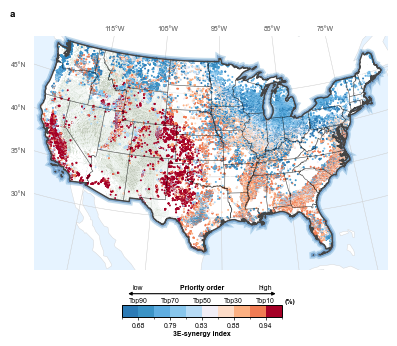

In [17]:
fig_geo2, ax_map = plot_ccd_optimized_global_style_with_dem(df_pixel_optimized_data, us_states_4326, dem_us, us_nation)
fig_geo2.savefig("figure/US_figure/ccd_optimized_with_dem_300dpi.png", dpi=300)
fig_geo2.savefig("figure/US_figure/ccd_optimized_with_dem_300dpi.pdf" ,dpi=300)

## 1.3 Under demand constrain


In [28]:
%matplotlib inline

def _add_demand_pie_chart(fig, ax, within_count, exceeds_count, 
                          pos_x=0.85, pos_y=0.10, size=0.12):
    """
    在图表右下角添加需求约束饼图
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        图表对象
    ax : matplotlib.axes.Axes
        主坐标轴对象
    within_count : int
        未超出需求的pixel数量
    exceeds_count : int
        超出需求的pixel数量
    pos_x : float
        饼图x位置（相对于figure，0-1）
    pos_y : float
        饼图y位置（相对于figure，0-1）
    size : float
        饼图大小（相对于figure宽度）
    """
    import numpy as np
    
    # 计算比例
    total = within_count + exceeds_count
    if total == 0:
        return
    
    within_pct = within_count / total * 100
    exceeds_pct = exceeds_count / total * 100
    
    # 创建饼图axes（大小与colorbar类似）
    pie_ax = fig.add_axes([pos_x, pos_y, size, size])
    pie_ax.set_aspect('equal')

    # 定义颜色（与主图配色一致）
    # 顺序：[within_count, exceeds_count]
    colors = ['#d24b3a', '#2c7bb6']  # 红色系（未超出），蓝色系（超出）

    # "explode"用来让两个扇形稍微分裂一点
    explode = [0.15, 0.15]  # 两个扇形都稍微分开一些，可根据需要调整

    wedges, texts, autotexts = pie_ax.pie(
        [within_count, exceeds_count],
        labels=['', ''],
        colors=colors,
        autopct='%d%%',
        startangle=90,
        textprops={'fontsize': 5, 'ha': 'center', 'va': 'center'},
        wedgeprops={'linewidth': 0.2, 'edgecolor': 'white'},
        labeldistance=0.45,
        explode=explode
    )
    
    # 调整百分比文字大小和样式
    for autotext in autotexts:
        autotext.set_fontsize(5)
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # 在饼图上方左右两侧添加标签（去除颜色指示点）
    # 左侧标签：Within（红色系）
    pie_ax.text(-1.15, 1.2, 'Within', 
                ha='center', va='bottom', 
                fontsize=5, fontweight='bold', color='black',
                transform=pie_ax.transData)
    
    # 右侧标签：Exceeds（蓝色系）
    pie_ax.text(1.15, 1.2, 'Exceed', 
                ha='center', va='bottom', 
                fontsize=5, fontweight='bold', color='black',
                transform=pie_ax.transData)
    
    pie_ax.set_xticks([])
    pie_ax.set_yticks([])
    for spine in pie_ax.spines.values():
        spine.set_visible(False)
    
    return pie_ax

In [29]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
import matplotlib.patches as mpatches
from shapely import make_valid
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.ops import unary_union
from scipy import stats

def plot_ccd_optimized_global_style_with_dem_demand_constrained(
    pixel_optimized_data,
    us_states_gdf,
    dem_data,
    us_nation,
    demand_constrained=False,
    exceeds_demand_col=None,
    state_col='NAME'  # 明确指定州列名为 'NAME'
):
    """
    绘制CCD优先区地图 - 支持需求约束版本（双color bar模式）
    
    Parameters:
    -----------
    pixel_optimized_data : pd.DataFrame
        包含 lat, lon, ccd_optimized 等列，如果需求约束，需要包含 exceeds_demand 列
        必须包含 'NAME' 列（州名）
    us_states_gdf : gpd.GeoDataFrame
        美国州界GeoDataFrame，必须包含 'NAME' 列（州名）
    dem_data : xarray DataArray
        DEM数据
    us_nation : gpd.GeoDataFrame
        美国国界GeoDataFrame
    demand_constrained : bool
        是否应用需求约束，默认False
    exceeds_demand_col : str, optional
        超出需求标记的列名，默认'exceeds_demand'
    state_col : str, default 'NAME'
        州标签列名，默认'NAME'
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
    from pyproj import Transformer
    import matplotlib.patches as mpatches
    from shapely.geometry import box

    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    fig, ax = plt.subplots(1, 1, figsize=(100/25.4,85/25.4))
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff') 
    ax.set_autoscale_on(False)

    usa_bounds_main = {'lon_min': -125, 'lon_max': -65,
                        'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
                usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    margin_x = (xmax - xmin) * 0.02
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05

    xmin -= margin_x
    xmax += margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax += margin_y

    ax.set_position([0.07, 0.13, 0.9, 0.81])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)
    _draw_glow_outline_outside(ax, us_nation_albers,
                                line_color="#444444", line_width=1,
                                widths_km=(0, 30, 50),
                                alphas=(0.95, 0.5, 0.3),
                                colors=("#08336e", "#105ca4", "#3888c0"))
    
    # ==================== 州界绘制（根据是否有exceeds_demand）====================
    if demand_constrained and exceeds_demand_col and exceeds_demand_col in pixel_optimized_data.columns:
        # 检查pixel数据中是否有州标签列
        if state_col in pixel_optimized_data.columns and 'NAME' in us_states_albers.columns:
            # 识别哪些州有exceeds_demand的pixel
            exceeds_pixels = pixel_optimized_data[
                pixel_optimized_data[exceeds_demand_col] == True
            ]
            
            # 获取有exceeds_demand的州名（转换为字符串并统一格式）
            if len(exceeds_pixels) > 0 and state_col in exceeds_pixels.columns:
                states_with_exceeds = exceeds_pixels[state_col].dropna().unique()
                # 转换为字符串并统一为大写，以便匹配
                states_with_exceeds_set = set([str(s).strip().upper() for s in states_with_exceeds])
            else:
                states_with_exceeds_set = set()
            
            # 为州界GeoDataFrame添加标记列
            us_states_albers['has_exceeds'] = us_states_albers['NAME'].apply(
                lambda x: str(x).strip().upper() in states_with_exceeds_set
            )
            
            # 分离有exceeds_demand的州和没有的州
            states_without_exceeds_gdf = us_states_albers[us_states_albers['has_exceeds'] == False]
            states_with_exceeds_gdf = us_states_albers[us_states_albers['has_exceeds'] == True]
            
            if len(states_without_exceeds_gdf) > 0:
                # 注意：matplotlib 的 hatch 线条粗细主要受 linewidths 控制，但pattern本身不会更细，只有线宽可调
                states_without_exceeds_gdf.plot(
                    ax=ax, 
                    color='none',
                    edgecolor='black', 
                    linewidth=0.4, 
                    alpha=0.6, 
                    hatch='///',
                    linewidths=0.2,  
                    zorder=8
                )
            
            # 有exceeds_demand的州保持原来的绘制风格（黑色边界，不填充）
            if len(states_with_exceeds_gdf) > 0:
                states_with_exceeds_gdf.plot(
                    ax=ax, 
                    color='none', 
                    edgecolor='black',
                    linewidth=0.4, 
                    alpha=0.4, 
                    zorder=9
                )
            
            print(f"✅ 州界颜色标记完成:")
            print(f"   • 阴影填充（无exceeds_demand）: {len(states_without_exceeds_gdf)} 个州")
            print(f"   • 保持原样（有exceeds_demand）: {len(states_with_exceeds_gdf)} 个州")
            if len(states_with_exceeds_gdf) > 0:
                print(f"   • 有exceeds_demand的州: {', '.join(states_with_exceeds_gdf['NAME'].head(10).tolist())}")
        else:
            # 如果找不到州标签列，使用默认绘制
            print(f"⚠️ 未找到州标签列（pixel: {state_col}, states: NAME），使用默认黑色边界")
            us_states_albers.plot(ax=ax, color='none', edgecolor='black',
                                linewidth=0.4, alpha=0.4, zorder=9)
    else:
        # 如果不应用需求约束，使用默认绘制
        us_states_albers.plot(ax=ax, color='none', edgecolor='black',
                            linewidth=0.4, alpha=0.4, zorder=9)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks,
                                usa_bounds_main, proj_fwd, proj_inv)

    x_proj, y_proj = transformer.transform(
        pixel_optimized_data['lon'].values,
        pixel_optimized_data['lat'].values)

    ccd_values = np.round(pixel_optimized_data['ccd_optimized'].values, 2)
    
    # 如果应用需求约束，使用双color bar模式
    if demand_constrained:
        if exceeds_demand_col is None:
            exceeds_demand_col = 'exceeds_demand'
        
        if exceeds_demand_col in pixel_optimized_data.columns:
            exceeds_mask = pixel_optimized_data[exceeds_demand_col].values
            
            # 未超出需求的pixel（使用红色系）
            within_mask = ~exceeds_mask
            # 超出需求的pixel（使用蓝色系）
            exceeds_mask_bool = exceeds_mask.astype(bool)
            
            # 统计数量（用于饼图）
            within_count = within_mask.sum()
            exceeds_count = exceeds_mask_bool.sum()
            
            within_colors = ['#f1eef6','#fddcc8','#fcb082','#f07b53','#d24b3a','#a50026']
            within_cmap = LinearSegmentedColormap.from_list("within_demand", within_colors, N=6)
            

            exceeds_colors = ['#b7dbf5','#88c6ec','#60aee1','#3b93c6','#2c7bb6']
            exceeds_cmap = LinearSegmentedColormap.from_list("exceeds_demand", exceeds_colors, N=6)
            
            percentile_bins = [0, 20, 40, 60, 80, 100]

            if within_mask.sum() > 0:
                within_ccd = ccd_values[within_mask]
                within_bins = np.percentile(within_ccd, percentile_bins)
                within_norm = BoundaryNorm(within_bins, ncolors=within_cmap.N)
            else:
                within_bins = None
                within_norm = None

            if exceeds_mask_bool.sum() > 0:
                exceeds_ccd = ccd_values[exceeds_mask_bool]
                exceeds_bins = np.percentile(exceeds_ccd, percentile_bins)
                exceeds_norm = BoundaryNorm(exceeds_bins, ncolors=exceeds_cmap.N)
            else:
                exceeds_bins = None
                exceeds_norm = None
            
            # 绘制未超出需求的pixel（红色系）
            if within_mask.sum() > 0 and within_norm is not None:
                scatter_within = ax.scatter(
                    x_proj[within_mask], y_proj[within_mask], 
                    c=ccd_values[within_mask], 
                    cmap=within_cmap, norm=within_norm,
                    s=1, alpha=1.0, edgecolors='none', zorder=6  
                )
            else:
                scatter_within = None
            
            # 绘制超出需求的pixel（蓝色系）
            if exceeds_mask_bool.sum() > 0 and exceeds_norm is not None:
                scatter_exceeds = ax.scatter(
                    x_proj[exceeds_mask_bool], y_proj[exceeds_mask_bool], 
                    c=ccd_values[exceeds_mask_bool], 
                    cmap=exceeds_cmap, norm=exceeds_norm,
                    s=1, alpha=1.0, edgecolors='none', zorder=5  
                )
            else:
                scatter_exceeds = None
            
            # 绘制背景地图
            _draw_background_map(ax, usa_bounds_main)
            
            # 创建双color bar
            pos = ax.get_position()
            c_w = 0.28  # 每个colorbar的宽度
            c_h = 0.03
            c_gap = 0.08  # 两个colorbar之间的间距
            
            # 左侧colorbar（未超出需求，红色系）
            if scatter_within is not None and within_bins is not None:
                c_left_within = pos.x0 + 0.01 * pos.width
                cax_within = fig.add_axes([c_left_within, 0.07, c_w, c_h])
                cax_within.set_in_layout(False)
                cb_within = fig.colorbar(scatter_within, cax=cax_within, orientation='horizontal')

                # 显示所有tick（0, 20, 40, 60, 80, 100对应的值）
                cb_within.set_ticks(within_bins)
                cb_within.set_ticklabels([f"{v:.2f}" for v in within_bins])

                cax_within.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
                cb_within.outline.set_linewidth(0.7)

                # Top标签：对应top80, top60, top40, top20（从右到左，即从高到低）
                top_labels = ['Top80', 'Top60', 'Top40', 'Top20']
                top_percentiles = [80, 60, 40, 20]
                for pct, label in zip(top_percentiles, top_labels):
                    bin_idx = len(within_bins) - 1 - (pct // 20)
                    if 0 <= bin_idx < len(within_bins):
                        tick_value = within_bins[bin_idx]
                        x_disp = cax_within.transData.transform((tick_value, 0))[0]
                        x_frac = cax_within.transAxes.inverted().transform((x_disp, 0))[0]
                        cax_within.text(
                            x_frac, 1.15, label,
                            transform=cax_within.transAxes,
                            ha='center', va='bottom', fontsize=5)
                # 添加 % 符号
                cax_within.text(1.05, 1.1, "(%)", ha='center', va='bottom', fontsize=5, 
                                fontweight='bold', transform=cax_within.transAxes)

                # 添加箭头（左侧，指向右边）
                cax_within.annotate(
                    "",
                    xy=(0.98, 2), xytext=(0.02, 2),
                    arrowprops=dict(arrowstyle="->", lw=0.8, color='black'),
                    xycoords=cax_within.transAxes
                )

                # within demand 文本放在箭头上方
                cax_within.text(0.5, 2.28, "Within demand", ha='center', va='bottom',
                               fontsize=5, fontweight='bold', transform=cax_within.transAxes)
                # 标题紧跟cax_within，底部略下
                cax_within.text(1.2, -1.2, "3E-synergy index", ha='center', va='top', fontsize=5,
                    fontweight='bold', transform=cax_within.transAxes)

            # 右侧colorbar（超出需求，蓝色系）
            if scatter_exceeds is not None and exceeds_bins is not None:
                c_left_exceeds = pos.x0 + c_w + c_gap
                cax_exceeds = fig.add_axes([c_left_exceeds, 0.07, c_w, c_h])
                cax_exceeds.set_in_layout(False)
                cb_exceeds = fig.colorbar(scatter_exceeds, cax=cax_exceeds, orientation='horizontal')

                # 显示所有tick（0, 20, 40, 60, 80, 100对应的值）
                cb_exceeds.set_ticks(exceeds_bins)
                cb_exceeds.set_ticklabels([f"{v:.2f}" for v in exceeds_bins])

                cax_exceeds.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
                cb_exceeds.outline.set_linewidth(0.7)

                # Top标签：对应top80, top60, top40, top20（从右到左，即从高到低）
                top_labels = ['Top80', 'Top60', 'Top40', 'Top20']
                top_percentiles = [80, 60, 40, 20]
                for pct, label in zip(top_percentiles, top_labels):
                    bin_idx = len(exceeds_bins) - 1 - (pct // 20)
                    if 0 <= bin_idx < len(exceeds_bins):
                        tick_value = exceeds_bins[bin_idx]
                        x_disp = cax_exceeds.transData.transform((tick_value, 0))[0]
                        x_frac = cax_exceeds.transAxes.inverted().transform((x_disp, 0))[0]
                        cax_exceeds.text(
                            x_frac, 1.15, label,
                            transform=cax_exceeds.transAxes,
                            ha='center', va='bottom', fontsize=5)
                # 添加 % 符号
                cax_exceeds.text(1.05, 1.1, "(%)", ha='center', va='bottom', fontsize=5, 
                                 fontweight='bold', transform=cax_exceeds.transAxes)

                # 先添加箭头
                cax_exceeds.annotate(
                    "",
                    xy=(0.98, 2), xytext=(0.02, 2),
                    arrowprops=dict(arrowstyle="->", lw=0.8, color='black'),
                    xycoords=cax_exceeds.transAxes
                )
                # exceeds demand 放到箭头上方
                cax_exceeds.text(0.5, 2.28, "Exceed demand", ha='center', va='bottom', 
                                fontsize=5, fontweight='bold', transform=cax_exceeds.transAxes)
            
            # 添加饼图（右下角）
            _add_demand_pie_chart(fig, ax, within_count, exceeds_count,
                                pos_x=0.8, pos_y=0.01, size=0.13)

    
    # 如果不应用需求约束，使用原始单color bar模式
    if not demand_constrained:
        diverging_colors = ['#2c7bb6','#3b93c6','#60aee1','#88c6ec','#b7dbf5',
                    '#f1eef6','#fddcc8','#fcb082','#f07b53','#d24b3a','#a50026']
        ccd_cmap = LinearSegmentedColormap.from_list("ccd_diverging", diverging_colors, N=11)
        ccd_bins = np.percentile(ccd_values, [0,10,20,30,40,50,60,70,80,90,100])
        ccd_norm = BoundaryNorm(ccd_bins, ncolors=ccd_cmap.N)

        # 绘制所有pixel的scatter（保持统一的color bar）
        scatter = ax.scatter(x_proj, y_proj, c=ccd_values, cmap=ccd_cmap,
                            norm=ccd_norm, s=2, alpha=1.0, edgecolors='none',
                            zorder=5)
        _draw_background_map(ax, usa_bounds_main)

        # ---------- 色条（锚在地图里，宽度 ~ 地图宽的 35%） ----------
        pos = ax.get_position()
        c_w = 0.45 * pos.width
        c_h = 0.03
        c_left   = pos.x0 + 0.25 * pos.width
        c_bottom = 0.07
        cax = fig.add_axes([c_left, c_bottom, c_w, c_h])
        cax.set_in_layout(False)
        cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
        cb.set_ticks(ccd_bins[1::2])
        cb.set_ticklabels([f"{v:.2f}" for v in ccd_bins[1::2]])
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)
        
        # 顶部 Top% 标签
        top_labels = [f"Top{p}" for p in range(10,101,20)][::-1]
        for loc, lab in zip(cb.get_ticks(), top_labels):
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, lab, transform=cax.transAxes,
                     ha='center', va='bottom', fontsize=5)
        
        # Priority order 居中于colorbar上方
        cax.text(1.05, 1.1, "(%)", ha='center', va='bottom', fontsize=5, 
                         fontweight='bold', transform=cax.transAxes)
        cax.text(0.5, 2.3, "Priority order", ha='center', va='bottom', fontsize=5, fontweight='bold', transform=cax.transAxes)
        
        # Arrow: bidirectional, horizontal, full width
        cax.annotate(
            "",
            xy=(0.98, 2), xytext=(0.02, 2),
            arrowprops=dict(arrowstyle="<|-|>", lw=0.8, color='black'),
            xycoords=cax.transAxes
        )
        
        # 标注low, high
        cax.text(0.1, 2.3, "low", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
        cax.text(0.9, 2.3, "high", ha='center', va='bottom', fontsize=5, transform=cax.transAxes)
        
        cax.text(0.5, -1.1, "3E-synergy index", ha='center', va='top', fontsize=5, 
                    fontweight='bold', transform=cax.transAxes)
    
    fig.canvas.draw()
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    panel_label = 'a'
    fig.text(0.01, 0.99, panel_label, ha='left', va='top', fontsize=7, fontweight='bold',
     bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

    return fig, ax

print("✓ 支持需求约束双color bar的绘图函数已定义（包含饼图和州界阴影标记）")

✓ 支持需求约束双color bar的绘图函数已定义（包含饼图和州界阴影标记）


执行需求约束下的CCD优先区绘制...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\3774521512.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


✅ 州界颜色标记完成:
   • 阴影填充（无exceeds_demand）: 16 个州
   • 保持原样（有exceeds_demand）: 33 个州
   • 有exceeds_demand的州: Texas, New Mexico, Oklahoma, California, Kansas, Colorado, Delaware, Florida, Louisiana, Mississippi
✅ 需求约束版本图片已保存
   • 文件: figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.png
   • 文件: figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.pdf

绘制无约束版本（对比）...


C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\3774521512.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


✅ 无约束版本图片已保存


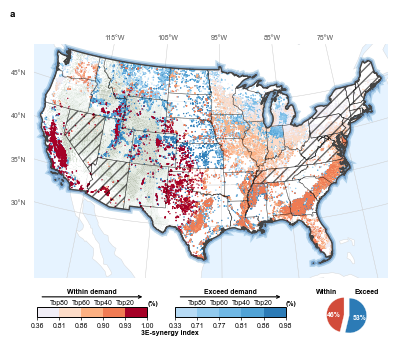

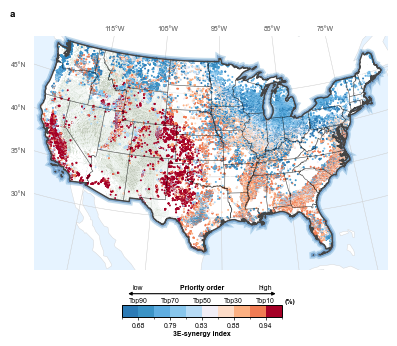

In [30]:
# ===== 执行需求约束下的CCD优先区绘制 =====

print("执行需求约束下的CCD优先区绘制...")

# 使用merged_data_with_states（包含州标签、power_pixel和exceeds_demand标记）
if 'exceeds_demand' in merged_data_with_states.columns:
    # 需求约束版本
    fig_demand, ax_demand = plot_ccd_optimized_global_style_with_dem_demand_constrained(
        merged_data_with_states,
        us_states_4326,
        dem_us,
        us_nation,
        demand_constrained=True,
        exceeds_demand_col='exceeds_demand'
    )
    
    # 保存图片
    fig_demand.savefig("figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.png", dpi=300)
    fig_demand.savefig("figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.pdf", dpi=300)
    
    print("✅ 需求约束版本图片已保存")
    print("   • 文件: figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.png")
    print("   • 文件: figure/US_figure/ccd_optimized_with_dem_demand_constrained_300dpi.pdf")
else:
    print("⚠️ merged_data_with_states中缺少'exceeds_demand'列，请先运行步骤3计算截断点")
    
# 同时绘制无约束版本（保留原有功能）
print("\n绘制无约束版本（对比）...")
fig_no_constraint, ax_no_constraint = plot_ccd_optimized_global_style_with_dem(
    merged_data_for_analysis,  # 使用原始数据，不包含exceeds_demand标记
    us_states_4326,
    dem_us,
    us_nation
)
fig_no_constraint.savefig("figure/US_figure/ccd_optimized_with_dem_no_constraint_300dpi.png", dpi=300)
fig_no_constraint.savefig("figure/US_figure/ccd_optimized_with_dem_no_constraint_300dpi.pdf", dpi=300)
print("✅ 无约束版本图片已保存")


In [31]:
us_states_4326

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.7268 35.93584, -75.71826 3..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.7424 37.80835, -75.7415 37..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.8677 29.86155, -88.86566 2..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19158 42.03537, -83.18992 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23483 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [32]:
merged_data_with_states

,lat,lon,predicted_prob,gmm_density,sample_type,LNCS_expect,net_npv_usd,area_m2,E_yr_pixel,ccd_optimized,pv_potential_dens,power_generation_kwha,Expectation_net_benefit,NAME,STATE,power_pixel,exceeds_demand
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,811.854595,1.186559e+06,776295.361002,1.958127e+08,0.940305,5568.344207,7.567199e+07,4756.489612,Florida,FLORIDA,1.958127e+08,False
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,1348.189022,1.024540e+06,775385.854124,1.913273e+08,0.828012,5447.174926,7.402534e+07,4098.985904,Florida,FLORIDA,1.913273e+08,False
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,971.186274,1.012824e+06,775385.854124,1.910215e+08,0.882208,5438.469092,7.390703e+07,4467.282818,Florida,FLORIDA,1.910215e+08,False
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,972.811005,1.006151e+06,775332.207938,1.908320e+08,0.880366,5433.449375,7.383881e+07,4460.638370,Florida,FLORIDA,1.908320e+08,False
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,968.544647,1.034704e+06,775332.207938,1.915894e+08,0.888518,5455.012162,7.413184e+07,4486.467516,Florida,FLORIDA,1.915894e+08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,377.830800,-1.040777e+06,563356.382622,1.180457e+08,0.790359,4625.717362,6.286200e+07,4247.886562,North Dakota,NORTH DAKOTA,1.180457e+08,True
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,307.516600,-1.044904e+06,563356.382622,1.178997e+08,0.800732,4619.997412,6.278426e+07,4312.480812,North Dakota,NORTH DAKOTA,1.178997e+08,True
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,324.674320,-1.070065e+06,563356.382622,1.170071e+08,0.757385,4585.017928,6.230891e+07,4260.343608,North Dakota,NORTH DAKOTA,1.170071e+08,True
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,323.374660,-1.067688e+06,563356.382622,1.170906e+08,0.691242,4588.290785,6.235338e+07,4264.916125,North Dakota,NORTH DAKOTA,1.170906e+08,True


# 2、Radar Plot

## 2.1 Calculation of Expectations

In [41]:
import numpy as np 
import pandas as pd 

'''
指针：Result第一段有关政策期望产出
数据：主要相关各个维度的排序方案以及期望产出
计算：
'''


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis


# 环境维度的变量
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit': 'Expectation_net_benefit'})

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})

# 协同指数的变量
coordinate_data = df_analysis[['lat', 'lon', 'ccd_optimized']].copy()

# 合并所有变量（增加协同指数维度）
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer') \
                      .merge(coordinate_data, on=['lat', 'lon'], how='outer')




In [42]:
# 计算各排序方案的期望值

import numpy as np 
import pandas as pd 
from scipy import stats

def calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95):
    """
    计算各个维度优先区方案的平均效率、变异系数和置信区间
    增加基于 ccd_optimized 的排序统计
    优化：统一列名，消除NaN
    """
    
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score', 'Environmental'),
        ('Expectation_net_benefit', 'Emission Mitigation', 't', 'Emission'),
        ('avg_npv', 'Economic Feasibility', 'USD', 'Economic'),
        ('ccd_optimized', 'Coordination Index', 'CCD', 'Coordination')
    ]
    
    area_values = merged_data_for_plot['area_m2'].values / 10000  # ha
    total_area = area_values.sum()
    
    def percentage_to_01(pct): 
        return pct / 100.0
    
    def calculate_integral(x, y):
        if len(x) < 2: 
            return 0.0
        if x[0] > x[-1]:
            x = x[::-1]
            y = y[::-1]
        return np.trapz(y, x)
    
    all_integrals = {}
    
    for variable_name, variable_label, unit, short_name in variables:
        dens = merged_data_for_plot[variable_name].values.astype(float)
        if variable_name == 'Expectation_net_benefit':
            dens = dens / 0.27
        total_vals = dens * area_values
        integrals = {}
        idx_sort = np.argsort(total_vals)[::-1]
        cum_ben = np.cumsum(total_vals[idx_sort])
        cum_pct = np.arange(1, len(cum_ben) + 1) / len(cum_ben) * 100
        cum_ben = np.concatenate([[0], cum_ben])
        cum_pct = np.concatenate([[0], cum_pct])
        x01 = percentage_to_01(cum_pct)
        integral_main = calculate_integral(x01, cum_ben) / total_area
        integrals[short_name] = integral_main
        for other_var_name, other_var_label, _, other_short_name in variables:
            if other_var_name == variable_name:
                continue
            other_dens = merged_data_for_plot[other_var_name].values.astype(float)
            if other_var_name == 'Expectation_net_benefit':
                other_dens = other_dens / 0.27
            other_total = other_dens * area_values
            idx_cross = np.argsort(other_total)[::-1]
            cross_cum_ben = np.cumsum(total_vals[idx_cross])
            cross_cum_pct = np.arange(1, len(cross_cum_ben) + 1) / len(cross_cum_ben) * 100
            cross_cum_ben = np.concatenate([[0], cross_cum_ben])
            cross_cum_pct = np.concatenate([[0], cross_cum_pct])
            x01 = percentage_to_01(cross_cum_pct)
            integral_cross = calculate_integral(x01, cross_cum_ben) / total_area
            integrals[other_short_name] = integral_cross
        all_integrals[variable_name] = integrals
    
    sort_methods = ['Environmental', 'Emission', 'Economic', 'Coordination']
    results = []
    alpha = 1 - confidence_level
    
    for variable_name, variable_label, unit, short_name in variables:
        integrals = all_integrals[variable_name]
        values = [integrals[method] for method in sort_methods]
        is_economic = variable_label.strip().startswith("Economic Feasibility")
        if is_economic:
            values = [val / 1000 for val in values]  # 转换为K thousand
        values_array = np.array(values)
        n = len(values_array)
        mean_val = np.mean(values_array)
        std_val = np.std(values_array, ddof=1)
        cv = (std_val / mean_val) if mean_val != 0 else 0

        sem = std_val / np.sqrt(n)
        df_freedom = n - 1
        t_critical = stats.t.ppf(1 - alpha/2, df_freedom)
        margin_of_error = t_critical * sem
        ci_lower = mean_val - margin_of_error
        ci_upper = mean_val + margin_of_error
        relative_error = (margin_of_error / abs(mean_val) * 100) if mean_val != 0 else np.inf

        result_row = {
            'Target': variable_label,
            'Variable_Name': variable_name,
            'Unit': unit,
        }
        for method, val in zip(sort_methods, values):
            result_row[f'Sort_by_{method}'] = val
        result_row['Mean'] = mean_val
        result_row['±Error'] = margin_of_error
        result_row['Mean±Error'] = f"{mean_val:.6e} ± {margin_of_error:.6e}" if not is_economic else f"{mean_val:.2f} ± {margin_of_error:.2f}"
        result_row['CI_Lower'] = ci_lower
        result_row['CI_Upper'] = ci_upper
        result_row['Std'] = std_val
        result_row['CV'] = cv
        result_row['Relative_Error_%'] = relative_error
        result_row['Sample_Size'] = n
        results.append(result_row)
    
    results_df = pd.DataFrame(results)
    return results_df

# 执行分析
results_df = calculate_integration_scores_with_cv_and_ccd(merged_data_for_plot, confidence_level=0.95)

# 显示完整的DataFrame（无NaN）
display(results_df)

,Target,Variable_Name,Unit,Sort_by_Environmental,Sort_by_Emission,Sort_by_Economic,Sort_by_Coordination,Mean,±Error,Mean±Error,CI_Lower,CI_Upper,Std,CV,Relative_Error_%,Sample_Size
0,Environmental Suitability,predicted_prob,Score,0.495094,0.418586,0.427797,0.437895,0.444843,0.054764,4.448429e-01 ± 5.476384e-02,0.390079,0.499607,0.034416,0.077367,12.310826,4
1,Emission Mitigation,Expectation_net_benefit,t,9091.399775,9670.772218,9535.870418,9520.660006,9454.675605,400.041659,9.454676e+03 ± 4.000417e+02,9054.633946,9854.717263,251.405127,0.026591,4.231152,4
2,Economic Feasibility,avg_npv,USD,81.024652,201.619722,226.943716,177.448589,171.759170,101.481741,171.76 ± 101.48,70.277428,273.240911,63.775933,0.371310,59.083740,4
3,Coordination Index,ccd_optimized,CCD,0.427783,0.441661,0.438002,0.450104,0.439387,0.014716,4.393874e-01 ± 1.471601e-02,0.424671,0.454103,0.009248,0.021048,3.349211,4


## 2.2 Helper

In [43]:
def _interp_radius_at(theta, angs, rads):
    """在多边形上插值：给定角 theta，返回该角度处外框线(边)的半径"""
    import numpy as np
    angs = np.asarray(angs, dtype=float)
    rads = np.asarray(rads, dtype=float)
    angs_ext = np.concatenate([angs, [angs[0] + 2*np.pi]])
    rads_ext = np.concatenate([rads, [rads[0]]])
    th = float(theta)
    if th < angs_ext[0]:
        th += 2*np.pi
    i = np.searchsorted(angs_ext, th, side='right') - 1
    i = int(np.clip(i, 0, len(angs_ext) - 2))
    a0, a1 = angs_ext[i], angs_ext[i+1]
    t = (th - a0) / (a1 - a0 + 1e-12)
    return rads_ext[i] + t * (rads_ext[i+1] - rads_ext[i])

def place_value_label_toward(ax, vertex_ang, vertex_r, text, *,
                             target_theta_deg,
                             base_angles, base_norm,
                             inner_radius=0.80,
                             ring_margin=0.03,        # 与内环的最小距离(到文本外沿)
                             poly_margin=0.02,        # 与多边形外框线的最小径向距离
                             min_point_gap=0.03,      # 与顶点最小径向距离(考虑marker)
                             radial_shift=-0.04,      # 相对顶点的默认径向位移(负=向内)
                             fontsize=5, marker_size_pt=6):
    """
    将数值文本放到“向 target_theta_deg 方向”的位置，保持水平、黑色、无白底，
    并满足与顶点/外框线/内圆环的安全间距。
    """
    import numpy as np
    fp = FontProperties(family="Arial", size=fontsize, weight="bold")

    # 目标角（绝对极角）
    theta = np.deg2rad(float(target_theta_deg))

    # --- 像素换算(径向/切向) ---
    trans = ax.transData
    dpi = ax.figure.dpi
    p0 = trans.transform((theta, vertex_r))
    p_r1 = trans.transform((theta, vertex_r + 1.0))      # 径向 +1
    p_t1 = trans.transform((theta + 1.0, vertex_r))      # 角向 +1 rad
    px_per_dr     = np.hypot(*(p_r1 - p0)) or 1.0
    px_per_dtheta = np.hypot(*(p_t1 - p0)) or 1.0

    # 文本宽/高（pt→px）
    tp = TextPath((0, 0), text, prop=fp)
    w_pt = tp.get_extents().width
    h_pt = tp.get_extents().height
    half_w_px = (w_pt * dpi / 72.0) / 2.0
    half_h_px = (h_pt * dpi / 72.0) / 2.0
    half_h_dr = half_h_px / px_per_dr
    half_w_rad = half_w_px / px_per_dtheta

    # 顶点 marker 半径(转径向单位)
    marker_rad_px = (marker_size_pt / 2.0) * dpi / 72.0
    marker_rad_dr = marker_rad_px / px_per_dr

    # 径向安全范围（文本外沿不能碰内环；不能小于0）
    r_min = 0.02 + half_h_dr
    r_max = inner_radius - ring_margin - half_h_dr
    r_max = max(r_min, r_max)

    # 初始半径：在顶点基础上做默认径向位移
    r_tgt = np.clip(vertex_r + radial_shift, r_min, r_max)

    # 与“顶点”的最小径向间隙（包含 marker 和文本半高）
    min_gap_dr = max(min_point_gap, marker_rad_dr + 0.01) + half_h_dr
    if abs(r_tgt - vertex_r) < min_gap_dr:
        if radial_shift < 0:
            r_tgt = max(vertex_r - min_gap_dr, r_min)
        else:
            r_tgt = min(vertex_r + min_gap_dr, r_max)

    # 与“多边形外框线”的最小径向间隙
    r_edge = _interp_radius_at(theta, base_angles, base_norm)
    need_gap = poly_margin + half_h_dr
    if abs(r_tgt - r_edge) < need_gap:
        # 远离外框线：按默认方向(向内)优先
        if (r_tgt <= r_edge):
            r_tgt = max(r_edge - need_gap, r_min)
        else:
            r_tgt = min(r_edge + need_gap, r_max)

    # 最终放置（水平、黑字、无白底）
    ax.text(theta, r_tgt, text,
            ha='center', va='center',
            fontsize=fontsize, fontweight='bold', color='black',
            rotation=0, rotation_mode='anchor', zorder=9)


def draw_text_on_arc(ax, text, theta_center, radius,
                     fontproperties=None, letter_spacing=1.0,
                     fit_to_segment=True,
                     segment_span_deg=120, segment_margin_deg=12,
                     radius_offset=0.0):
    """
    在极坐标圆弧上按曲率绘制文字（整段统一方向/翻转，逐字沿切线）。
      - 上半圆(0≤θc≤π)：顺时针排布（角度递减），不翻转
      - 下半圆(π<θc<2π)：逆时针排布（角度递增），整体 +180° 翻转
    radius_offset: 控制文字距离圆心的偏移量（正值向外，负值向内）
    """
    if fontproperties is None:
        fontproperties = FontProperties(family="Arial", size=6, weight="bold")

    # 1) 逐字测宽（pt->px）
    dpi = ax.figure.dpi
    glyph_px = []
    spacing_factor = 1.1  # 原为1.0，适当加大
    for ch in text:
        if ch == ' ':
            space_w_pt = 0.35 * fontproperties.get_size()
            glyph_px.append(space_w_pt * dpi / 72.0 * letter_spacing * spacing_factor)
            continue
        tp = TextPath((0, 0), ch, prop=fontproperties)
        w_pt = tp.get_extents().width
        glyph_px.append(max(0.01, w_pt) * dpi / 72.0 * letter_spacing * spacing_factor)
    total_px = sum(glyph_px)

    # 2) px/rad 换算
    t0 = float(theta_center)
    p0 = ax.transData.transform((t0, radius))
    p1 = ax.transData.transform((t0 + 1.0, radius))  # +1 rad
    px_per_rad = np.hypot(*(p1 - p0)) or 1.0

    # 3) 超长则压缩到扇段宽度内
    if fit_to_segment:
        max_span_rad = np.deg2rad(max(5.0, segment_span_deg - 2*segment_margin_deg))
        need_rad = total_px / px_per_rad
        if need_rad > max_span_rad:
            scale = max_span_rad / need_rad
            glyph_px = [w * scale for w in glyph_px]
            total_px = sum(glyph_px)

    # 4) 以中心角判断半圆与翻转（整段一次性）
    theta_mod = t0 % (2*np.pi)
    on_upper = (0.0 <= theta_mod <= np.pi)
    flip_whole = (theta_mod > np.pi)          # 仅下半圆整体翻转
    step_sign  = (-1.0 if on_upper else +1.0) # 上半递减, 下半递增

    # 布局起点（让整段以中心角居中）
    start_theta = t0 - step_sign * (total_px / (2.0 * px_per_rad))

    # 5) 逐字绘制（沿切线；整段统一翻转）
    cursor = start_theta
    for wpx, ch in zip(glyph_px, text):
        theta_mid = cursor + step_sign * (wpx / (2.0 * px_per_rad))
        deg = np.degrees(theta_mid)

        rot = deg - 90.0
        if flip_whole:
            rot += 180.0

        # 这里控制向圆心移动距离：radius + radius_offset
        txt = ax.text(theta_mid, radius + radius_offset, ch,
                      fontproperties=fontproperties,
                      ha='center', va='center',
                      rotation=rot, rotation_mode='anchor',
                      clip_on=True, zorder=10)
        # txt.set_path_effects([pe.withStroke(linewidth=1.5, foreground='white')])

        cursor += step_sign * (wpx / px_per_rad)

## 2.3 Main Rader

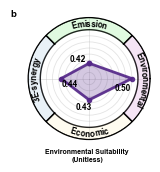

已生成 predicted_prob 的积分雷达图


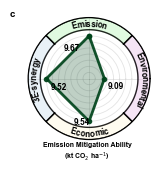

已生成 Expectation_net_benefit 的积分雷达图


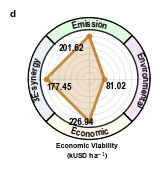

已生成 avg_npv 的积分雷达图
所有积分雷达图生成完成！


In [44]:
import os
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as pe




def create_integration_radar_charts(results_df):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.font_manager import FontProperties
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })
    os.makedirs("figure/US_figure", exist_ok=True)

    
    # ===== 变量定义 =====
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation Ability', 'Gt '),
        ('avg_npv', 'Economic Viability', 'USD')
    ]
    env_color = '#542788'
    carbon_color = '#00441b'
    economic_color = '#bf812d'
    coordination_color = '#3c6b99'
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color,
        'ccd_optimized': coordination_color
    }
    panel_labels = ['b', 'c', 'd']
    categories = ['Emission', 'Environmental', 'Economic', 'Coordination']
    custom_angles = [np.pi/2, 0, 3*np.pi/2, np.pi]
    sort_methods = categories

    all_integrals = {}
    for var, label, unit in variables:
        subset = results_df[results_df['Variable_Name'] == var].iloc[0]
        # If method is 'Coordination', rename it to '3E-synergy'
        all_integrals[var] = {
            ('3E-synergy' if method == 'Coordination' else method): subset[f'Sort_by_{method}']
            for method in sort_methods
        }
        

    for idx, (variable_name, variable_label, unit) in enumerate(variables):
        fig, ax = plt.subplots(1, 1, figsize=(40/25.4, 40/25.4), subplot_kw=dict(projection='polar'))
        plt.subplots_adjust(top=0.95, bottom=0.15)  # 图像上移一点
        integrals = all_integrals[variable_name]

        values = [
            integrals['Emission'],
            integrals['Environmental'],
            integrals['Economic'],
            integrals['3E-synergy']
        ]
        # 数量级显示
        if variable_name == 'predicted_prob':
            display_values = [v for v in values]; unit_suffix = '\n(Unitless)'
        elif variable_name == 'Expectation_net_benefit':
            display_values = [v/1e3 for v in values]; unit_suffix = '\n(kt CO$_2$ ha$^{-1}$)'
        elif variable_name == 'avg_npv':
            display_values = [v for v in values]; unit_suffix = '\n(kUSD ha$^{-1}$)'
        else:
            display_values = values; unit_suffix = ''
        
        vmin = vmax = None
        if display_values:
            vmin, vmax = min(display_values), max(display_values)
            if vmax > vmin:
                vr = vmax - vmin
                center_offset = vmin - 0.3 * vr
                arange = (vmax - center_offset) / 0.7
                norm_vals = [(v - center_offset) / arange for v in display_values]
                norm_vals = [max(0, min(0.7, v)) for v in norm_vals]
                mn = min(norm_vals)
                if mn < 0.2:
                    s = 0.25 / max(mn, 1e-9)
                    norm_vals = [min(0.7, v*s) for v in norm_vals]
            else:
                norm_vals = [0.5] * len(display_values)
        else:
            norm_vals = [0] * len(categories)

        # 角度/闭合：保留“未闭合”版本用于顶点标注
        base_angles = custom_angles.copy()
        base_norm   = norm_vals[:]
        angles_closed = base_angles + base_angles[:1]
        norm_closed   = base_norm + base_norm[:1]

        # ===== 角度刻度（不显示文字，但用于绘制辐射网格）=====
        ax.set_xticks(base_angles)
        ax.set_xticklabels(['']*len(base_angles))

        # ===== 绘制面/线 =====
        ax.plot(angles_closed, norm_closed, 'o-', linewidth=2,
                color=variable_colors[variable_name], alpha=0.9, zorder=5,markersize=3)
        ax.fill(angles_closed, norm_closed, alpha=0.25,
                color=variable_colors[variable_name], zorder=4)
        outer_radius, inner_radius = 1.0, 0.80

        ring_colors = {
            'Emission': '#90EE90',
            'Environmental': '#DDA0DD',
            'Economic': '#FFF5CC',
            '3E-synergy': '#B3CDE3'
        }

        sector_half = np.deg2rad(45)
        for angle, cat in zip(base_angles, ring_colors.keys()):
            start_angle = angle - sector_half
            end_angle = angle + sector_half
            theta_ring = np.linspace(start_angle, end_angle, 120)
            inner_circle = np.full_like(theta_ring, inner_radius)
            outer_circle = np.full_like(theta_ring, outer_radius)

            ax.plot(theta_ring, inner_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot(theta_ring, outer_circle, 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([start_angle, start_angle], [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)
            ax.plot([end_angle, end_angle], [inner_radius, outer_radius], 'k-', lw=1.0, alpha=0.85, zorder=2)

            ring_theta = np.concatenate([theta_ring, theta_ring[::-1]])
            ring_radius = np.concatenate([inner_circle, outer_circle[::-1]])
            ax.fill(ring_theta, ring_radius, color=ring_colors[cat], alpha=0.28, zorder=1)

            draw_text_on_arc(
                ax, cat, theta_center=angle, radius=inner_radius + 0.12,
                fontproperties=FontProperties(family="Arial", size=6, weight="bold"),
                letter_spacing=1.05, fit_to_segment=True,
                segment_span_deg=90, segment_margin_deg=12, radius_offset=-0.02
            )

        target_theta_map = {
            'Emission': 120,
            'Environmental': -15,
            'Economic': 260,
            'Coordination': 195
        }
        radial_shift_map = {
            'Emission': -0.035,
            'Environmental': 0.02,
            'Economic': 0.045,
            'Coordination': -0.015
        }

        for angle, val, r_norm, cat in zip(base_angles, display_values, base_norm, categories):
            label_text = f'{val:.2f}'

            # "Environmental", idx==0 向下移动（数值更负）
            if cat == 'Environmental' and idx == 0:
                radial_shift = -0.01  # 比原-0.1更明显向下
            elif cat == 'Environmental' and idx in [1, 2]:
                radial_shift = 0.2
            elif cat == 'Emission' and idx in [0]:
                radial_shift = 0
            else:
                radial_shift = radial_shift_map.get(cat, -0.02)

            place_value_label_toward(
                ax, angle, r_norm, label_text,
                target_theta_deg=target_theta_map.get(cat, np.degrees(angle)),
                base_angles=base_angles, base_norm=base_norm,
                inner_radius=inner_radius,
                ring_margin=0.03,
                poly_margin=0.02,
                min_point_gap=0.03,
                radial_shift=radial_shift,
                fontsize=6,
                marker_size_pt=6
            )

        ax.set_ylim(0, 1.0)
        radial_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        ax.set_yticks(radial_levels)
        ax.set_yticklabels([''] * len(radial_levels))
        ax.grid(True, alpha=0.35, linewidth=0.6)
        ax.set_axisbelow(True)

        fig.text(0.01, 0.99, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)
        fig.text(0.5, 0.02, f'{variable_label}{unit_suffix}',
                 ha='center', va='bottom', fontsize=5, fontweight='bold',
                 transform=fig.transFigure, zorder=100)

        if variable_name == 'avg_npv' and display_values:
            if vmax > vmin:
                vr = vmax - vmin
                center_offset = vmin - 0.3 * vr
                arange = (vmax - center_offset) / 0.7
                zero_norm = (0 - center_offset) / arange
                zero_norm = max(0, min(0.7, zero_norm))
                theta_dense = np.linspace(0, 2 * np.pi, 400)
                ax.plot(theta_dense, np.full_like(theta_dense, zero_norm), '--', color='#800000',
                        linewidth=0.8, alpha=0.85, zorder=3)

        png_path = f"figure/US_figure/integration_radar_{variable_name}_individual.png"
        pdf_path = f"figure/US_figure/integration_radar_{variable_name}_individual.pdf"
        # 将背景设置为透明
        fig.savefig(png_path, dpi=300, facecolor='none', transparent=True, pad_inches=0.08)
        fig.canvas.draw()
        fig.savefig(pdf_path, dpi=300, facecolor='none', transparent=True, pad_inches=0.08)
        plt.show()
        plt.close(fig)

        print(f"已生成 {variable_name} 的积分雷达图")

    print("所有积分雷达图生成完成！")
    return fig, ax


fig, ax = create_integration_radar_charts(results_df)


In [45]:
results_df

,Target,Variable_Name,Unit,Sort_by_Environmental,Sort_by_Emission,Sort_by_Economic,Sort_by_Coordination,Mean,±Error,Mean±Error,CI_Lower,CI_Upper,Std,CV,Relative_Error_%,Sample_Size
0,Environmental Suitability,predicted_prob,Score,0.495094,0.418586,0.427797,0.437895,0.444843,0.054764,4.448429e-01 ± 5.476384e-02,0.390079,0.499607,0.034416,0.077367,12.310826,4
1,Emission Mitigation,Expectation_net_benefit,t,9091.399775,9670.772218,9535.870418,9520.660006,9454.675605,400.041659,9.454676e+03 ± 4.000417e+02,9054.633946,9854.717263,251.405127,0.026591,4.231152,4
2,Economic Feasibility,avg_npv,USD,81.024652,201.619722,226.943716,177.448589,171.759170,101.481741,171.76 ± 101.48,70.277428,273.240911,63.775933,0.371310,59.083740,4
3,Coordination Index,ccd_optimized,CCD,0.427783,0.441661,0.438002,0.450104,0.439387,0.014716,4.393874e-01 ± 1.471601e-02,0.424671,0.454103,0.009248,0.021048,3.349211,4


# 3、Single-color

## 3.1 Helper

In [46]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """渲染地形"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # 抽稀栅格
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # 地形配色
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """绘制国界线光晕效果"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """绘制背景地图"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """Override: only render the horizontal color bar."""
    pos = ax.get_position()
    left = pos.x0 + 0.25 * pos.width
    bottom = 0.08
    width = 0.45 * pos.width
    height = 0.035

    cax = fig.add_axes([left, bottom, width, height])
    cax.set_in_layout(False)
    cax.set_zorder(50)
    cb = fig.colorbar(scatter, cax=cax, orientation='horizontal')
    cb.set_ticks(var_bins[1::2])

    tick_vals = var_bins[1::2]
    if variable_name == 'avg_npv':
        tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
    elif variable_name == 'predicted_prob':
        tick_labels = [f'{v:.2f}' for v in tick_vals]
    elif variable_name == 'Expectation_net_benefit':
        tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
    else:
        tick_labels = [f'{v:.0f}' for v in tick_vals]
    cb.set_ticklabels(tick_labels)

    cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
    cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
    cb.outline.set_linewidth(0.7)

    percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
    for loc, label in zip(cb.get_ticks(), percentile_labels):
        x_disp = cax.transData.transform((loc, 0))[0]
        x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
        cax.text(x_frac, 1.3, label, transform=cax.transAxes,
                 ha='center', va='bottom', fontsize=5, clip_on=False,
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))
    cax.text(1.02, 1.3, '(%)', ha='center', va='bottom', fontsize=5,
             fontweight='bold', transform=cax.transAxes,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))

    for ch in cax.get_children():
        try:
            ch.set_clip_path(cax.patch)
        except Exception:
            pass

    if variable_name == 'net_npv_usd':
        unit_display = f'Economic viability {unit} '
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} '
    else:
        unit_display = f'Economic viability '

    cax.text(0.5, -1.11, unit_display, ha='center', va='top', fontsize=5,
             fontweight='bold', transform=cax.transAxes,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, edgecolor='none'))
    return cax, cb


def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """绘制经纬度网格，标签显示在上方和右方（曲线网格）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线，裁剪到地图区域
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在顶部边界寻找交点
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择最左侧的
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                                   edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 只绘制地图内的曲线网格线
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧边界寻找交点
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}°N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # 如果交点有多个，选择中间的
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}°N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                                   edgecolor='none'))
    """绘制经纬度网格，标签显示在上方和左侧（曲线网格，去除右侧标签）"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # 轴框与四边
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # 获取经纬度范围
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # 经度刻度和网格线（曲线）
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 在顶部显示标签
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # 检查与已有标签的最小距离
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # 在上方显示标签
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}°W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7, 
                               edgecolor='none'))

    # 纬度刻度和网格线（曲线）
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # 绘制曲线网格线
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # 只在左侧显示标签（不在右侧）
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}°N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.7,
                           edgecolor='none'))

## 3.2 Single-color

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot,
    us_states_gdf,
    dem_data,
    variable_name,
    title=None,
    unit=None,
    colors=None,
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False,
    demand_constrained=False,
    state_demand_dict=None,
    merged_data_with_states=None
):
    """
    绘制单变量地图，简化版本

    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        包含经纬度和变量数据的数据框
    us_states_gdf : GeoDataFrame
        美国州界数据
    dem_data : xarray.Dataset
        DEM地形数据
    variable_name : str
        要绘制的变量名
    title : str, optional
        图表标题
    unit : str, optional
        变量单位
    colors : list, optional
        颜色列表
    cmap_type : str, default 'sequential'
        颜色映射类型
    add_north_arrow_and_scalebar : bool, default True
        是否添加指北针和比例尺
    add_embedding_points : bool, default False
        是否添加嵌入点
    demand_constrained : bool, default False
        是否应用需求约束（按单目标排序，仅显示未超出需求的像素）
    state_demand_dict : dict, optional
        各州需求字典，格式为 {STATE: demand_kwh}
    merged_data_with_states : DataFrame, optional
        包含州标签和power_pixel的数据框，用于需求约束计算

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })


    # 创建更大的图形和坐标轴
    fig, ax = plt.subplots(1, 1, figsize=(58/25.4, 40/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')

    # ==================== 2. 地理边界设置 ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # 处理州界数据
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # 处理国界线
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. 坐标变换设置 ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. 地图范围计算 ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # 减小边界，让图幅更大
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # 设置坐标轴位置和范围 - 图像整体向上移动，比例不变
    ax.set_position([0.1, 0.05, 0.8, 0.8])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. 数据坐标转换（先转换全部数据，后续会根据需求约束过滤）====================
    x_proj_all, y_proj_all = transformer.transform(merged_data_for_plot['lon'].values, 
                                                    merged_data_for_plot['lat'].values)

    # ==================== 6. 地形渲染 ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. 地图元素绘制 ====================
    # 绘制国界线光晕效果
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. 取消坐标轴和网格 ====================
    # 移除坐标轴边框
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 30,35,40,45]
    
    # 绘制曲线网格线（标签显示在上方）
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. 背景地图 ====================
    # _draw_background_map(ax, usa_bounds_main)

    # ==================== 9.5. 需求约束逻辑（如果启用）====================
    if demand_constrained and state_demand_dict is not None and merged_data_with_states is not None:
        print("应用需求约束逻辑...")
        
        # 确保merged_data_for_plot有索引，以便后续匹配
        merged_data_for_plot = merged_data_for_plot.reset_index(drop=True)
        
        # 创建标记列，标识是否超出需求
        merged_data_for_plot['within_demand'] = True
        
        # 确保merged_data_with_states有相同的索引或可以匹配
        if 'STATE' not in merged_data_with_states.columns or 'power_pixel' not in merged_data_with_states.columns:
            print("⚠️ 警告: merged_data_with_states缺少STATE或power_pixel列，跳过需求约束")
            demand_constrained = False
        else:
            # 通过经纬度匹配数据
            if 'lon' in merged_data_for_plot.columns and 'lat' in merged_data_for_plot.columns:
                # 如果merged_data_for_plot已有这些列，先删除以避免冲突
                merge_cols = ['lon', 'lat', 'STATE', 'power_pixel']
                existing_cols = [col for col in merge_cols if col in merged_data_for_plot.columns and col not in ['lon', 'lat']]
                if existing_cols:
                    # 如果已有STATE或power_pixel，使用_from_states后缀
                    merged_data_for_plot = merged_data_for_plot.merge(
                        merged_data_with_states[merge_cols],
                        on=['lon', 'lat'],
                        how='left',
                        suffixes=('', '_from_states')
                    )
                    # 如果合并后产生了_from_states列，使用它们
                    for col in existing_cols:
                        if f'{col}_from_states' in merged_data_for_plot.columns:
                            merged_data_for_plot[col] = merged_data_for_plot[f'{col}_from_states'].fillna(merged_data_for_plot[col])
                            merged_data_for_plot = merged_data_for_plot.drop(columns=[f'{col}_from_states'])
                else:
                    # 如果没有冲突，直接合并
                    merged_data_for_plot = merged_data_for_plot.merge(
                        merged_data_with_states[merge_cols],
                        on=['lon', 'lat'],
                        how='left'
                    )
                
                # 对每个州计算截断点
                data_with_states = merged_data_for_plot[merged_data_for_plot['STATE'].notna()].copy()
                unique_states = data_with_states['STATE'].unique()
                
                for state in unique_states:
                    state_data = data_with_states[data_with_states['STATE'] == state].copy()
                    
                    if len(state_data) == 0:
                        continue
                    
                    # 获取该州的需求（kWh）
                    state_demand_kwh = state_demand_dict.get(state, None)
                    
                    if state_demand_kwh is None:
                        continue
                    
                    # 获取variable_name和power_pixel
                    var_values_state = state_data[variable_name].values
                    power_pixel_state = state_data['power_pixel'].values
                    
                    # 按variable_name降序排序
                    var_indices = np.argsort(var_values_state)[::-1]
                    
                    # 计算累积发电量
                    power_cumulative = np.cumsum(power_pixel_state[var_indices])
                    
                    # 找到满足该州需求的截断点
                    cutoff_mask = power_cumulative >= state_demand_kwh
                    if cutoff_mask.any():
                        cutoff_idx = np.where(cutoff_mask)[0][0]
                        # 截断点之后的pixel标记为超出需求
                        exceeded_indices = var_indices[cutoff_idx + 1:]
                        state_indices = state_data.index[exceeded_indices]
                        merged_data_for_plot.loc[state_indices, 'within_demand'] = False
                


    # ==================== 10. 数据可视化 ====================
    # 如果启用需求约束，只绘制未超出需求的像素
    if demand_constrained and 'within_demand' in merged_data_for_plot.columns:
        plot_data = merged_data_for_plot[merged_data_for_plot['within_demand'] == True].copy()
    else:
        plot_data = merged_data_for_plot.copy()
    
    var_values = np.round(np.asarray(plot_data[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    # 获取过滤后数据的坐标
    if demand_constrained and 'within_demand' in merged_data_for_plot.columns:
        # 使用布尔索引来匹配坐标
        within_mask = merged_data_for_plot['within_demand'] == True
        x_proj = x_proj_all[within_mask]
        y_proj = y_proj_all[within_mask]
    else:
        x_proj = x_proj_all
        y_proj = y_proj_all
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. 颜色条（传入var_values用于绘制分布图）====================
    # _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. 最终处理 ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


应用需求约束逻辑...
✅ 需求约束计算完成
   • 未超出需求的pixel数: 32913
   • 超出需求的pixel数: 37424


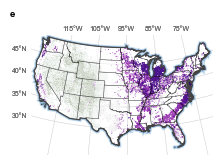

C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


应用需求约束逻辑...
✅ 需求约束计算完成
   • 未超出需求的pixel数: 32129
   • 超出需求的pixel数: 38208


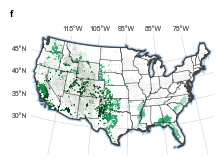

C:\Users\zpy10\AppData\Local\Temp\ipykernel_3800\1647133101.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


应用需求约束逻辑...
✅ 需求约束计算完成
   • 未超出需求的pixel数: 32082
   • 超出需求的pixel数: 38255


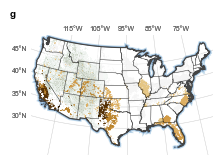

所有图片生成完成！


In [ ]:

# variables_config = [
#     {
#         'name': 'predicted_prob',
#         'title': 'Environmental Potential',
#         'unit': 'Probability',
#         # 采用单色渐变，逐渐变深为紫色
#         'colors': [
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#ce93d8',
#             '#ba68c8',
#             '#ab47bc',
#             '#9c27b0',
#             '#7b1fa2',
#             '#4a148c'
#         ],
#         'filename': 'environmental score'
#     },
#     {
#         'name': 'Expectation_net_benefit', 
#         'title': 'Carbon Mitigation Potential',
#         'unit': 'kt CO$_2$ ha$^{-1}$',
#         # 采用单色渐变，逐渐变深为绿色，到'#00441b'
#         'colors': [
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#43b984',
#             '#2fa76a',
#             '#219150',
#             '#005824',
#             '#00441b'
#         ],

#         'filename': 'carbon_mitigation_potential'
#     },
#     {
#         'name': 'avg_npv',
#         'title': 'Economic Potential', 
#         'unit': 'k USD ha$^{-1}$',
#         'colors': [
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#f5f5f5',
#             '#e5c684', '#ddaf62', '#d29b46', '#ba832c', '#a36d1c', '#543005'
#         ],
#         'filename': 'economic_potential'
#     }
# ]

# 生成三个单独的图
panel_labels = ['e', 'f', 'g']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points,
            demand_constrained=True,  # 启用需求约束
            state_demand_dict=state_demand_dict,  # 传入需求字典
            merged_data_with_states=merged_data_with_states  # 传入包含州标签的数据
        )

        fig.text(
            0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.2, lw=0), zorder=100
        )

        # 保存图片
        filename_png = f"figure/US_figure/{var_config['filename']}_priority_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_priority_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white')
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white')

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

# 4、Curve Plot

=== 数据预处理：使用merged_data_for_plot ===
数据行数: 70337
总面积: 4703357.18 公顷


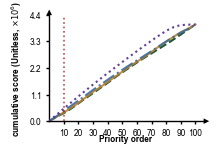

已生成 predicted_prob 的交叉目标分析图


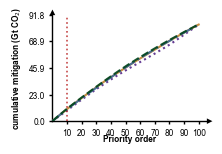

已生成 Expectation_net_benefit 的交叉目标分析图


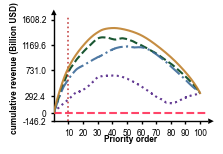

已生成 avg_npv 的交叉目标分析图
所有交叉目标分析图生成完成！


In [49]:
def create_cross_target_analysis_individual(merged_data_for_plot):
    """
    创建交叉目标分析图，逐个输出三个子图，参照plot_single_variable_nature_style的尺寸设计
    直接使用merged_data_for_plot作为数据源
    """
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch, FancyArrowPatch
    
    # 设置字体参数，参考plot_single_variable_nature_style
    plt.rcParams.update({
        'font.size': 5, 'axes.titlesize': 5, 'axes.labelsize': 5,
        'xtick.labelsize': 5, 'ytick.labelsize': 5, 'legend.fontsize': 5,
        'font.family': 'Arial'
    })

    # 定义四个变量
    variables = [
        ('predicted_prob', 'Environmental Suitability', 'Score'),
        ('Expectation_net_benefit', 'Emission Mitigation', 'Mg C'),
        ('avg_npv', 'Economic Feasibility', 'USD'),
        ('ccd_optimized', 'Coordination Index', 'Index')
    ]
    plot_variables = variables[:3]

    # 修改颜色方案
    env_color = '#542788'   # 紫色
    carbon_color = '#00441b'  # 绿色
    economic_color = '#bf812d'  # 棕色
    coordination_color = '#3c6b99'  # 蓝灰

    # 映射变量名到颜色
    variable_colors = {
        'predicted_prob': env_color,
        'Expectation_net_benefit': carbon_color,
        'avg_npv': economic_color,
        'ccd_optimized': coordination_color
    }

    # 映射变量名到线型
    variable_linestyles = {
        'predicted_prob': ':',        # 点线
        'Expectation_net_benefit': '--',  # 虚线
        'avg_npv': '-',               # 实线
        'ccd_optimized': '-.'         # 点划线
    }

    # 面板标签
    panel_labels = ['', '', '']

    # ==================== 数据预处理 ====================
    print("=== 数据预处理：使用merged_data_for_plot ===")
    print(f"数据行数: {len(merged_data_for_plot)}")
    
    # 检查必要的列是否存在
    required_cols = ['lat', 'area_m2'] + [var[0] for var in variables]
    missing_cols = [col for col in required_cols if col not in merged_data_for_plot.columns]
    if missing_cols:
        raise ValueError(f"缺少必要的列: {missing_cols}")
    
    # 计算总面积
    area_values = merged_data_for_plot['area_m2'].values / 10000  # 转换为公顷
    print(f"总面积: {np.sum(area_values):.2f} 公顷")

    # 逐个生成图片
    for idx, (variable_name, variable_label, unit) in enumerate(plot_variables):
        fig, ax = plt.subplots(1, 1, figsize=(52/25.4, 36/25.4))  # 60mm x 40mm

        # 获取当前变量的数据
        benefit_density_values = merged_data_for_plot[variable_name].values
        if variable_name == 'Expectation_net_benefit':
            benefit_density_values = benefit_density_values / 0.27 

        if variable_name == 'predicted_prob':
            benefit_total_values = benefit_density_values * area_values
        else:
            benefit_total_values = benefit_density_values * area_values

        # 当前变量曲线（目标曲线）
        target_sorted_indices = np.argsort(benefit_total_values)[::-1]
        target_cumulative_benefits = np.cumsum(benefit_total_values[target_sorted_indices])
        target_cumulative_percentage = np.arange(1, len(target_cumulative_benefits) + 1) / len(target_cumulative_benefits) * 100
        target_cumulative_benefits = np.concatenate([[0], target_cumulative_benefits])
        target_cumulative_percentage = np.concatenate([[0], target_cumulative_percentage])

        # （交叉曲线）
        cross_curves_data = []
        for other_var_name, other_var_label, other_unit in variables:
            if other_var_name != variable_name:
                other_density_values = merged_data_for_plot[other_var_name].values
                if other_var_name == 'Expectation_net_benefit':
                    other_density_values = other_density_values / 0.27 
                if other_var_name == 'predicted_prob':
                    other_total_values = other_density_values * area_values
                else:
                    other_total_values = other_density_values * area_values
                
                cross_sorted_indices = np.argsort(other_total_values)[::-1]
                cross_cumulative_benefits = np.cumsum(benefit_total_values[cross_sorted_indices])
                cross_cumulative_percentage = np.arange(1, len(cross_cumulative_benefits) + 1) / len(cross_cumulative_benefits) * 100
                cross_cumulative_benefits = np.concatenate([[0], cross_cumulative_benefits])
                cross_cumulative_percentage = np.concatenate([[0], cross_cumulative_percentage])
                
                cross_curves_data.append({
                    'label': f'By {other_var_label.split(" ")[0]}',
                    'color': variable_colors[other_var_name],
                    'linestyle': variable_linestyles[other_var_name],
                    'percentage': cross_cumulative_percentage,
                    'benefits': cross_cumulative_benefits,
                    'var_name': other_var_name
                })

        # 绘制目标曲线（当前变量）
        target_color_current = variable_colors[variable_name]
        target_linestyle_current = variable_linestyles[variable_name]
        ax.plot(target_cumulative_percentage, target_cumulative_benefits,
                 color=target_color_current, linewidth=1.5, alpha=0.9, 
                 linestyle=target_linestyle_current, zorder=8,
                 label=f'{variable_label.split(" ")[0]}')

        # 绘制交叉曲线（其他两个变量）
        for curve in cross_curves_data:
            ax.plot(curve['percentage'], curve['benefits'],
                     color=curve['color'], linewidth=1.5, alpha=0.9, 
                     linestyle=curve['linestyle'], zorder=6,
                     label=curve['label'])

        # 特殊处理NPV的Y=0线和阴影
        if variable_name == 'avg_npv':
            ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=7,
                      label='Break-even Line')
            
            # 找到Economic曲线与Y=0轴的交点
            economic_negative_mask = target_cumulative_benefits < 0
            if np.any(economic_negative_mask):
                first_negative_idx = np.where(economic_negative_mask)[0][0]
                if first_negative_idx > 0:
                    x1, y1 = target_cumulative_percentage[first_negative_idx-1], target_cumulative_benefits[first_negative_idx-1]
                    x2, y2 = target_cumulative_percentage[first_negative_idx], target_cumulative_benefits[first_negative_idx]
                    
                    if y2 != y1:
                        intersection_x = x1 + (x2 - x1) * (0 - y1) / (y2 - y1)
                        ax.axvspan(intersection_x, 100, color='gray', alpha=0.3, zorder=1, 
                                   label='Negative Region')

        # X轴标签
        ax.text(0.5, -0.13, 'Priority order', transform=ax.transAxes, ha='center', va='top',
                fontsize=6, fontweight='bold')

        # 设置X轴刻度
        key_percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        xtick_positions = [p for p in key_percentages if p >= 10]
        xtick_labels = [f'{p}' for p in xtick_positions]
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, ha='center', fontsize=6)
        ax.set_xlim(0, 105)

        # 设置Y轴范围和格式化，并减少y轴刻度数量
        all_curves_min = target_cumulative_benefits.min()
        all_curves_max = target_cumulative_benefits.max()
        for curve in cross_curves_data:
            all_curves_min = min(all_curves_min, curve['benefits'].min())
            all_curves_max = max(all_curves_max, curve['benefits'].max())
        
        if variable_name == 'predicted_prob':
            # Environmental: 除以1e6，保留1位小数，显示1e6
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
            ax.set_ylabel('cumulative score (Unitless, $\\times 10^6$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'Expectation_net_benefit':
            # Emission: 除以1e9，保留1位小数，显示1e9
            ax.set_ylim(0, all_curves_max * 1.1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e9:.1f}'))
            ax.set_ylabel('cumulative mitigation (Gt CO$_2$)', fontsize=6, fontweight='bold')
            yticks = np.linspace(0, all_curves_max * 1.1, 5)
            ax.set_yticks(yticks)
        elif variable_name == 'avg_npv':
            # Economic: 除以1e9，保留1位小数，显示1e9
            y_range = all_curves_max - all_curves_min
            if y_range == 0:
                y_range = abs(all_curves_max) * 0.1
            y_min = all_curves_min - y_range * 0.1
            y_max = all_curves_max + y_range * 0.1
            ax.set_ylim(y_min, y_max*1.05)
            ax.set_ylabel('cumulative revenue (Billion USD)', fontsize=6, fontweight='bold', labelpad=1.2)

            # 生成yticks，并确保0会被标注出来
            yticks = np.linspace(y_min, y_max, 5)
            # 判断0是否已经在yticks里，如果不在，则插入
            if not np.isclose(yticks, 0).any() and (0 > yticks.min()) and (0 < yticks.max()):
                yticks = np.sort(np.append(yticks, 0))
            ax.set_yticks(yticks)
            
            def billion_formatter(x, pos):
                if np.isclose(x, 0):
                    return '0'
                return f'{x/1e9:.1f}'
            ax.yaxis.set_major_formatter(FuncFormatter(billion_formatter))

        # 10%分位线
        ax.axvline(10, color='#B71C1C', linestyle=':', linewidth=1.2, alpha=0.8, zorder=7)
        ax.text(0.10, 1.02, '', transform=ax.transAxes, ha='center', va='bottom', fontsize=5, color='#B71C1C')

        # 轴向箭头
        x_lim = ax.get_xlim()
        y_lim = ax.get_ylim()
        arrow_x = FancyArrowPatch(
            posA=(x_lim[1], 0),
            posB=(x_lim[1] + (x_lim[1] - x_lim[0]) * 0.06, 0),
            transform=ax.get_xaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_x.set_clip_on(False)
        ax.add_patch(arrow_x)

        arrow_y = FancyArrowPatch(
            posA=(0, y_lim[1]),
            posB=(0, y_lim[1] + (y_lim[1] - y_lim[0]) * 0.05),
            transform=ax.get_yaxis_transform(),
            arrowstyle='simple',
            color='black', linewidth=0, mutation_scale=8, zorder=9
        )
        arrow_y.set_clip_on(False)
        ax.add_patch(arrow_y)

        # 网格和样式设置
        # ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)  # 不需要网格，已注释
        ax.set_axisbelow(True)
        
        # 坐标轴样式设置
        ax.tick_params(axis='both', which='major', width=1, size=2, labelsize=6, color='black')
        # 设置坐标轴线的颜色和粗细
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')

        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # 布局调整 - 参照plot_single_variable_nature_style的坐标轴位置
        ax.set_position([0.2, 0.15, 0.75, 0.75])  
        fig.text(0.01, 1, panel_labels[idx], ha='left', va='top', fontsize=7, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # 保存图片
        filename_png = f"figure/US_figure/cross_target_{variable_name}_individual.png"
        filename_pdf = f"figure/US_figure/cross_target_{variable_name}_individual.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='white', pad_inches=0.1)
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='white', pad_inches=0.1)
        
        plt.show()
        plt.close(fig)
        
        print(f"已生成 {variable_name} 的交叉目标分析图")

    print("所有交叉目标分析图生成完成！")
    return fig, ax

# 执行函数
fig, ax = create_cross_target_analysis_individual(merged_data_for_plot)

In [50]:
merged_data_for_plot

,lat,lon,predicted_prob,gmm_density,sample_type,Expectation_net_benefit,area_m2,avg_npv,ccd_optimized
0,25.295834,-80.287500,0.947286,2.806133e+19,prediction,4756.489612,776295.361002,1.186559e+06,0.940305
1,25.437500,-80.537500,0.999397,5.399806e+21,prediction,4098.985904,775385.854124,1.024540e+06,0.828012
2,25.437500,-80.495834,0.963775,1.508036e+20,prediction,4467.282818,775385.854124,1.012824e+06,0.882208
3,25.445833,-80.454170,0.330575,1.800785e+16,prediction,4460.638370,775332.207938,1.006151e+06,0.880366
4,25.445833,-80.404170,0.999345,6.792866e+22,prediction,4486.467516,775332.207938,1.034704e+06,0.888518
...,...,...,...,...,...,...,...,...,...
70332,48.995834,-99.995834,0.989598,5.692829e+14,prediction,4247.886562,563356.382622,-1.040777e+06,0.790359
70333,48.995834,-99.987500,0.985191,1.413612e+14,prediction,4312.480812,563356.382622,-1.044904e+06,0.800732
70334,48.995834,-99.895836,0.965398,3.161397e+13,prediction,4260.343608,563356.382622,-1.070065e+06,0.757385
70335,48.995834,-99.887500,0.969823,6.767585e+13,prediction,4264.916125,563356.382622,-1.067688e+06,0.691242


merged_data_for_plot